# Librairies

In [1]:
import pandas as pd 
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString
import matplotlib.pylab as plt

# Load Data

In [86]:
# This is similar data - same technology to collect the data
gdf = gpd.read_file('raw/comptages.json')
gdf2 = gpd.read_file('raw/tmjo_par_sens_v85.geojson')

In [87]:
gdf.troncon = gdf.troncon.astype('int')
gdf.sort_values(by = ['troncon', 'date2'])[['troncon', 'date2', 'mjo_vl', 'mjo_pl']][:15]

,troncon,date2,mjo_vl,mjo_pl
2800,7,2015-02-18,952,9
2038,8,2013-11-26,1024,8
4940,8,2015-02-18,846,10
3216,22,2017-11-07,3969,153
3310,22,2018-10-25,3314,115
4830,36,2021-02-11,2648,314
4451,86,2018-05-29,3630,65
1901,88,2018-05-29,3104,162
3972,93,2013-06-14,1362,58
638,114,2017-11-16,1616,8


In [88]:
gdf2.sort_values(by = ['troncon', 'date_mesure'])[['troncon', 'date_mesure', 'total_vl', 'total_pl']][:15]
# Directed measurement share the same geometry so we'll keep only the aggregattion

,troncon,date_mesure,total_vl,total_pl
904,7.0,2015-02-19 00:00:00+00:00,952.0,9.0
2946,8.0,2013-11-27 00:00:00+00:00,1024.0,8.0
637,8.0,2015-02-19 00:00:00+00:00,846.0,10.0
1356,22.0,2017-11-08 00:00:00+00:00,3969.0,153.0
4886,22.0,2018-10-26 00:00:00+00:00,3314.0,115.0
1550,36.0,2021-02-12 00:00:00+00:00,2648.0,314.0
3507,86.0,2018-05-30 00:00:00+00:00,3630.0,65.0
630,88.0,2018-05-30 00:00:00+00:00,3104.0,162.0
1731,93.0,2013-06-15 00:00:00+00:00,1468.0,63.0
3141,114.0,2017-11-17 00:00:00+00:00,1616.0,8.0


In [89]:
# Create a second geometry for "retour"
# NW to SE
list(gdf2[gdf2.id == 10595].geometry.values[0].coords)

[(3.01182501438662, 50.64072787568368),
 (3.012521268323065, 50.64031957830055),
 (3.0129787499715217, 50.640051430983384)]

In [90]:
gdf2[gdf2.id == 10595][['aller_vl', 'retour_vl']] # Only aller not "retour"

,aller_vl,retour_vl
2327,218.0,NaN


In [91]:
gdf2[['aller_vl', 'aller_pl', 'aller_v85', 'date_mesure', 'geometry']]

,aller_vl,aller_pl,aller_v85,date_mesure,geometry
0,1017.0,27.0,36.0,2014-11-26 00:00:00+00:00,"LINESTRING (3.15684 50.73141, 3.15612 50.73175)"
1,203.0,4.0,39.0,2018-10-19 00:00:00+00:00,"LINESTRING (2.89973 50.66444, 2.89994 50.66434..."
2,1903.0,255.0,64.0,2019-10-10 00:00:00+00:00,"LINESTRING (3.02658 50.69299, 3.02626 50.69316..."
3,7367.0,261.0,61.0,2021-11-24 00:00:00+00:00,"LINESTRING (3.0994 50.61938, 3.09988 50.61901,..."
4,NaN,NaN,NaN,2022-08-01 00:00:00+00:00,"LINESTRING (3.07037 50.64154, 3.07069 50.64174..."
...,...,...,...,...,...
5393,NaN,NaN,NaN,2018-01-10 00:00:00+00:00,"LINESTRING (2.8859 50.6873, 2.886 50.687, 2.88..."
5394,251.0,15.0,37.0,2019-11-27 00:00:00+00:00,"LINESTRING (3.11621 50.63182, 3.11669 50.63243)"
5395,3669.0,40.0,58.0,2021-06-01 00:00:00+00:00,"LINESTRING (3.14751 50.7069, 3.14537 50.70558)"
5396,9672.0,141.0,48.0,2013-09-13 00:00:00+00:00,"LINESTRING (2.96491 50.635, 2.96541 50.6354, 2..."


In [92]:
gdf2['year'] = pd.to_datetime(gdf2.date_mesure).apply(lambda x : x.year)

In [93]:
# Aggregate where we have several measure on the same segment for the same year
gdf2 = gdf2.groupby(['troncon', 'year']).agg(
    aller_vl = ('aller_vl', 'mean'),
    aller_pl = ('aller_pl', 'mean'),
    aller_v85 = ('aller_v85', 'mean'),
     retour_vl = ('retour_vl', 'mean'),
    retour_pl = ('retour_pl', 'mean'),
    retour_v85 = ('retour_v85', 'mean'),
    geometry = ('geometry', lambda x:x.iloc[0])
).reset_index()

In [133]:
forward = gdf2[['aller_vl', 'aller_pl', 'aller_v85', 'year',  'geometry', 'troncon']].dropna().rename(
    columns = {
        'aller_vl':'mjo_vl', 'aller_pl':'mjo_pl', 'aller_v85':'s85'
    }
)
forward['type'] = 'aller'
back = gdf2[['retour_vl', 'retour_pl', 'retour_v85', 'year', 'geometry', 'troncon']].dropna().rename(
    columns = {
        'retour_vl':'mjo_vl', 'retour_pl':'mjo_pl', 'retour_v85':'s85'
    }
)
back['type'] = 'retour'
back['geometry'] = back['geometry'].apply(lambda x : LineString(list(x.coords)[::-1]))

# Combine both
gdf = pd.concat([forward, back])

In [134]:
gdf.columns

Index(['mjo_vl', 'mjo_pl', 's85', 'year', 'geometry', 'troncon', 'type'], dtype='object')

In [135]:
gdf.year.sort_values().unique()

array([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
       2023, 2024], dtype=int64)

In [136]:
gdf['AAWT'] = gdf['mjo_vl'] + gdf['mjo_pl']
# Véhicule léger + Poids Lourds = Tout véhicules
# Light vehicles + heavy ones = All vehicles

In [137]:
gdf.rename(columns = {
    'mjo_pl':'TR_AAWT',
}, inplace=True)

In [138]:
gdf = gpd.GeoDataFrame(
    gdf,
    geometry = 'geometry',
    crs = 'epsg:4326'
)

(2.6363754272460938, 3.3395900074020948, 50.401596333655, 50.8477897222086)

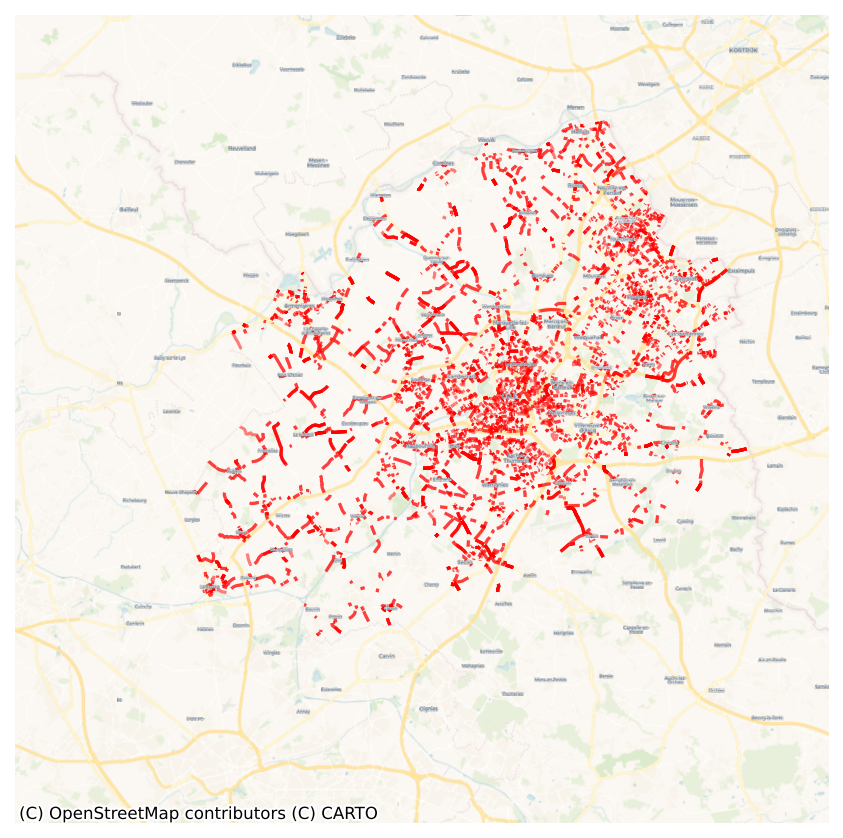

In [66]:
# Plot sensors
#plt.figure(figsize = (10,10), dpi = 300)
import contextily as cx
fig, ax = plt.subplots(figsize = (7,7), dpi = 150)
gdf.plot(ax=ax, color = 'r', markersize = 5, alpha = .5)
# Add context in backround
cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.CartoDB.VoyagerNoLabels)

cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.CartoDB.VoyagerOnlyLabels, zoom = 12)

# Remove lat lon
plt.axis('off')
plt.axis('auto')

# Map matching with OSM

In [103]:
import sys
from pathlib import Path

# Add the ../assets directory to sys.path
sys.path.append(str(Path("../../assets").resolve()))

from map_matching_OSM import lines_matching

In [139]:
gdf.shape

(8502, 8)

In [140]:
gdf.geometry.unique().size

6585

In [141]:
gdf.reset_index(inplace=True, drop=True)
gdf

,mjo_vl,TR_AAWT,s85,year,geometry,troncon,type,AAWT
0,952.0,9.0,48.0,2015,"LINESTRING (3.16375 50.61373, 3.16299 50.61408...",7.0,aller,961.0
1,1024.0,8.0,53.0,2013,"LINESTRING (3.16195 50.61464, 3.16189 50.61474...",8.0,aller,1032.0
2,846.0,10.0,58.0,2015,"LINESTRING (3.16195 50.61464, 3.16189 50.61474...",8.0,aller,856.0
3,1699.0,95.0,44.0,2017,"LINESTRING (3.13852 50.6581, 3.13945 50.6578)",22.0,aller,1794.0
4,1313.0,70.0,38.0,2018,"LINESTRING (3.13852 50.6581, 3.13945 50.6578)",22.0,aller,1383.0
...,...,...,...,...,...,...,...,...
8497,5430.0,128.0,50.0,2015,"LINESTRING (3.07778 50.6446, 3.0777 50.64434, ...",90987.0,retour,5558.0
8498,3356.0,39.0,50.0,2019,"LINESTRING (3.07778 50.6446, 3.0777 50.64434, ...",90987.0,retour,3395.0
8499,3434.0,27.0,48.0,2020,"LINESTRING (3.07778 50.6446, 3.0777 50.64434, ...",90987.0,retour,3461.0
8500,4849.0,121.0,47.0,2016,"LINESTRING (3.00555 50.64996, 3.00604 50.64964...",91003.0,retour,4970.0


In [118]:
gdf_unique = gdf.drop_duplicates(subset = ['geometry'])

In [119]:
gdf_unique = lines_matching(gdf_unique)

Main graph loaded
Node 36966619 not reachable from 139585024
Node 36966619 not reachable from 155843884
Node 1330536135 not reachable from 1649498502
Node 1649498502 not reachable from 1330536135
Node 1642095589 not reachable from 1330536135
Node 1334274984 not reachable from 1330536135
Node 1334274984 not reachable from 1330536135
Node 1330536135 not reachable from 1649498502
Node 55280889 not reachable from 1098518242
Node 53707300 not reachable from 1098518242
Node 63539503 not reachable from 1098518242
Node 255756259 not reachable from 1098518242
Node 142576112 not reachable from 1098518242
Node 142576112 not reachable from 1098518242
Node 1099467527 not reachable from 1098518242
Node 1099467527 not reachable from 1098518242
Node 187466484 not reachable from 1098518242
Node 53707300 not reachable from 1098518242
Node 166363848 not reachable from 1098518242
Node 142576112 not reachable from 1098518242
Node 59393732 not reachable from 1098518242
Node 253199335 not reachable from 1098

In [132]:
gdf_unique[['troncon', 'type']].duplicated().sum()

0

In [142]:
gdf = gdf.set_index(['troncon', 'type']).join(
    gdf_unique.set_index(['troncon', 'type'])[['osm_name', 'osm_type', 'osm_lanes', 'osm_oneway', 'osmid']],
    how = 'left'
).reset_index()
gdf

,troncon,type,mjo_vl,TR_AAWT,s85,year,geometry,AAWT,osm_name,osm_type,osm_lanes,osm_oneway,osmid
0,7.0,aller,952.0,9.0,48.0,2015,"LINESTRING (3.16375 50.61373, 3.16299 50.61408...",961.0,Rue de l'Abbé Cousin,residential,1.0,True,32694794.0
1,8.0,aller,1024.0,8.0,53.0,2013,"LINESTRING (3.16195 50.61464, 3.16189 50.61474...",1032.0,Rue de l'Abbé Cousin,residential,1.0,True,32694794.0
2,8.0,aller,846.0,10.0,58.0,2015,"LINESTRING (3.16195 50.61464, 3.16189 50.61474...",856.0,Rue de l'Abbé Cousin,residential,1.0,True,32694794.0
3,22.0,aller,1699.0,95.0,44.0,2017,"LINESTRING (3.13852 50.6581, 3.13945 50.6578)",1794.0,Boulevard Albert 1er,residential,1.0,True,675273318.0
4,22.0,aller,1313.0,70.0,38.0,2018,"LINESTRING (3.13852 50.6581, 3.13945 50.6578)",1383.0,Boulevard Albert 1er,residential,1.0,True,675273318.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8497,90987.0,retour,5430.0,128.0,50.0,2015,"LINESTRING (3.07778 50.6446, 3.0777 50.64434, ...",5558.0,Rue du Ballon,tertiary,2.0,NaN,124186687.0
8498,90987.0,retour,3356.0,39.0,50.0,2019,"LINESTRING (3.07778 50.6446, 3.0777 50.64434, ...",3395.0,Rue du Ballon,tertiary,2.0,NaN,124186687.0
8499,90987.0,retour,3434.0,27.0,48.0,2020,"LINESTRING (3.07778 50.6446, 3.0777 50.64434, ...",3461.0,Rue du Ballon,tertiary,2.0,NaN,124186687.0
8500,91003.0,retour,4849.0,121.0,47.0,2016,"LINESTRING (3.00555 50.64996, 3.00604 50.64964...",4970.0,Rue Eugène Descamps,tertiary,2.0,NaN,29189709.0


In [143]:
gdf[gdf.osmid.isna()]['type'].value_counts()

type
aller     115
retour     77
Name: count, dtype: int64

(2.6363754272460938, 3.3395900074020948, 50.401596333655, 50.8477897222086)

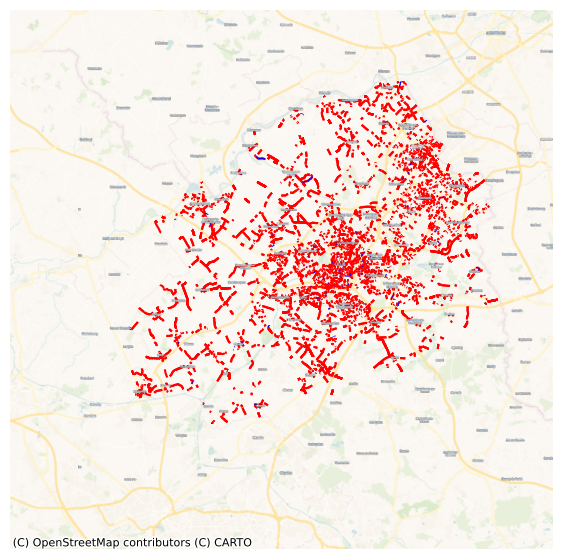

In [144]:
ax = gdf[gdf.osmid.notna()].plot(color = 'red', figsize = (7,7))
gdf[gdf.osmid.isna()].plot(ax=ax, color = 'blue', lw = .5)

# Add context in backround
cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.CartoDB.VoyagerNoLabels)

cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.CartoDB.VoyagerOnlyLabels, zoom = 12)

# Remove lat lon
plt.axis('off')
plt.axis('auto')

# Lines not matched are mostly outside of the city

In [19]:
# Here we don't have any street names to compare with
#gdf[['Street_name', 'osm_name']].values[:30]

In [145]:
gdf[gdf.troncon == 91003]

,troncon,type,mjo_vl,TR_AAWT,s85,year,geometry,AAWT,osm_name,osm_type,osm_lanes,osm_oneway,osmid
4336,91003.0,aller,5353.0,109.0,48.0,2016,"LINESTRING (3.00638 50.64944, 3.00604 50.64964...",5462.0,Rue Eugène Descamps,tertiary,2.0,NaN,29189709.0
4337,91003.0,aller,5270.0,71.0,48.0,2022,"LINESTRING (3.00638 50.64944, 3.00604 50.64964...",5341.0,Rue Eugène Descamps,tertiary,2.0,NaN,29189709.0
8500,91003.0,retour,4849.0,121.0,47.0,2016,"LINESTRING (3.00555 50.64996, 3.00604 50.64964...",4970.0,Rue Eugène Descamps,tertiary,2.0,NaN,29189709.0
8501,91003.0,retour,3990.0,90.0,50.0,2022,"LINESTRING (3.00555 50.64996, 3.00604 50.64964...",4080.0,Rue Eugène Descamps,tertiary,2.0,NaN,29189709.0


# Final save

In [147]:
# Saving
for year in range(2015, 2025) :
    # Extract corresponding year
    sub = gdf[gdf.year == year]
    print(year, sub.shape[0])
    sub[[
        'AAWT', 'TR_AAWT', 's85', 'geometry', 'osm_name', 'osm_type', 'osm_lanes', 'osm_oneway', 'osmid'
        ]].to_file(f'treated/Lille_AAWT_{year}.geojson')

2015 944
2016 770
2017 806
2018 844
2019 924
2020 569
2021 718
2022 918
2023 571
2024 532
